<h2>Configurações da máquina:  </h2>

**SO:**
___

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic


**Placa de vídeo:**
___

In [3]:
!nvidia-smi

Tue Dec 18 19:50:22 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Memória RAM:**
___

In [4]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        404M         10G        868K        1.6G         12G
Swap:            0B          0B          0B


**CPU:**
___

In [5]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust 

<h2>** 1º Instalando as depêndencias do projeto: **</h2>
___

In [6]:
!pip3 install CMake
!pip3 install dlib==19.10.0
!pip3 install face_recognition
!pip3 install imutils
!pip3 install opencv-python
!pip3 install matplotlib

    100% |████████████████████████████████| 3.3MB 10.7MB/s 
  Running setup.py bdist_wheel for dlib ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/64/ae/fc/c35f5515409d56baa3d6de414482cd2db477dd52731d7cb4cd
Successfully built dlib
  Found existing installation: dlib 19.16.0
    Uninstalling dlib-19.16.0:
      Successfully uninstalled dlib-19.16.0
    100% |████████████████████████████████| 100.2MB 273kB/s 
  Running setup.py bdist_wheel for face-recognition-models ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/

---
<h2>2º Treinamento: </h2>





Agora que temos todas as depêndencias do projeto instaladas podemos dar a permissão de acesso a arquivos do nosso google drive para que possamos executar o treinamento da nossa rede.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

baseDrive = '/content/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


O primeiro passo para conseguir realizar o reconhecimento facial é importar as bibliotecas necessárias:

In [0]:
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os

Agora temos que pegar os caminhos das nossas imagens do conjunto de dados de entrada:

In [9]:
caminhoImagens = baseDrive + 'trabalho-ia/jadson'

print("[INFO] quantificando faces ...")
imagePaths = list(paths.list_images(caminhoImagens))
print("[INFO] Faces quantificadas com sucesso: "+str(len(imagePaths)))

[INFO] quantificando faces ...
[INFO] Faces quantificadas com sucesso: 5


Com o caminho das imagens agora podemos inicializar a lista de codificações dos rostos conhecidos e desconhecidos. 

In [0]:
knownEncodings = []
knownNames = []

Agora vamos fazer um loop em cima de cada imagem do nosso diretório:

In [11]:
for (i, imagePath) in enumerate(imagePaths):
	# Extrair o nome da pessoa do caminho da imagem
	print("[INFO] PROCESSANDO IMAGEM {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]

	# Carregar a imagem de entrada e convertê-la de RGB (ordem OpenCV)
	# Para ordenar dlib (RGB)
	image = cv2.imread(imagePath)
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	# Detectar as coordenadas (x, y) das caixas delimitadoras
	# Correspondente a cada face na imagem de entrada
  # Sistemas de detecção: cnn ou hog.
	boxes = face_recognition.face_locations(rgb,
		model='cnn')
  
	# Calcular a incorporação facial para o rosto, caracteristicas.
	encodings = face_recognition.face_encodings(rgb, boxes)

	# loop sobre as codificações
	for encoding in encodings:
		# adicione cada codificação + nome ao nosso conjunto de nomes conhecidos e codificados
		knownEncodings.append(encoding)
		knownNames.append(name)
    
print('IMAGENS PROCESSADAS COM SUCESSO!')

[INFO] PROCESSANDO IMAGEM 1/5
[INFO] PROCESSANDO IMAGEM 2/5
[INFO] PROCESSANDO IMAGEM 3/5
[INFO] PROCESSANDO IMAGEM 4/5
[INFO] PROCESSANDO IMAGEM 5/5
IMAGENS PROCESSADAS COM SUCESSO!


Agora devemos salvar nosso arquivo de treino para o seu uso:

In [12]:
nomeEncode = 'treino-apresentacao.pickle'
print("[INFO] codificações de serialização...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open(baseDrive + 'trabalho-ia/' + nomeEncode, "wb")
f.write(pickle.dumps(data))
f.close()
print(nomeEncode, "salvo com sucesso!")

[INFO] codificações de serialização...
treino-apresentacao.pickle salvo com sucesso!


<h2>3º Reconhecendo as imagens </h2>
___

Agora vamos carregar nosso arquivo de treinamento para que possamos realizar o
treinamento:

In [13]:
# Carregar os rostos e os encaixes conhecidos

print("[INFO] carregando codificações ...")

data = pickle.loads(open(baseDrive + 'trabalho-ia/' + nomeEncode, "rb").read())

print('Treinamento carregado com sucesso!')

[INFO] carregando codificações ...
Treinamento carregado com sucesso!


Carrega a imagem de entrada e converte-a de BGR para RGB:

In [14]:
imagemEntrada = baseDrive + 'trabalho-ia/examples/teste1.jpg'

image = cv2.imread(imagemEntrada)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("[INFO] imagem carregada com sucesso...")

[INFO] imagem carregada com sucesso...




*   Detectar as coordenadas (x, y) das caixas delimitadoras correspondentes
*   Para cada face na imagem de entrada e, em seguida, calcule os encaixes faciais para cada rosto



In [15]:
print("[INFO] Identificando faces...")

boxes = face_recognition.face_locations(rgb,
	model='cnn')
# Model pode ser cnn ou hog
encodings = face_recognition.face_encodings(rgb, boxes)

print("[INFO] Faces detectadas...")

[INFO] Identificando faces...
[INFO] Faces detectadas...


Inicializar a lista de nomes para cada rosto detectado:

In [0]:
names = []

Laço sobre cada quadro:

In [17]:
for encoding in encodings:

  print("[INFO] PROCESSANDO...")

  # tentar combinar cada rosto na imagem de entrada para o nosso conhecido
  matches = face_recognition.compare_faces(data["encodings"], encoding)

  name = "????????"

  # verifique se encontramos uma correspondência
  if True in matches:
    # encontrar os índices de todos os rostos combinados, em seguida, inicializar um
    # dicionário para contar o número total de vezes que cada rosto
    # foi correspondido
    matchedIdxs = [i for (i, b) in enumerate(matches) if b]
    counts = {}

    # fazer um for sobre os índices correspondentes e manter uma contagem para
    # cada face do rosto reconhecida
    for i in matchedIdxs:
      name = data["names"][i]
      counts[name] = counts.get(name, 0) + 1

    # determinar a face reconhecida com o maior número de
    # votos (nota: no caso de um improvável empate, o Python
    # selecione a primeira entrada no dicionário)
    name = max(counts, key=counts.get)

  # atualizar a lista de nomes
  names.append(name)
print("[INFO] Finalizado...")

[INFO] PROCESSANDO...
[INFO] PROCESSANDO...
[INFO] Finalizado...


Loop sobre as faces reconhecidas:

In [0]:
for ((top, right, bottom, left), name) in zip(boxes, names):
  # Desenhe o nome da face prevista na imagem
  cv2.rectangle(rgb, (left, top), (right, bottom), (200, 0, 0), 2)
  y = top - 15 if top - 15 > 15 else top + 15
  cv2.putText(rgb, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 200, 0), 2)

Plotar a imagem:

---



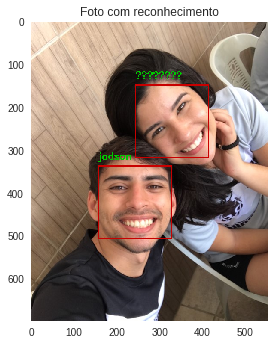

In [19]:
from matplotlib import pyplot as plt
plt.imshow(rgb)
plt.grid(None)
plt.title('Foto com reconhecimento')
plt.show()

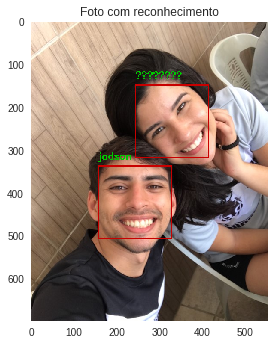

In [20]:
from matplotlib import pyplot as plt
plt.imshow(rgb)
plt.grid(None)
plt.title('Foto com reconhecimento')
plt.show()

<h2>Aplicações futuras</h2>


---

Treinamento da rede para reconhecimento de placas de carros para detectar veículos roubados e informar a algum orgão responsável. 